# Homework 3 Part 2 Task 1 - SubTask

### Read the example in 'basic_steps_classification_cv_hw3.ipynb': the code and data in this file will help you understand the steps of using random forest with GridSearchCV. Do NOT use the random data for the following sub-task. The code and comments in 'basic_steps_classification_cv_hw3.ipynb' are for reference only, as those are NOT designed exactly for the following sub-task.

### The sub-task:
### Create a new file, copy the cells [1]  to [10] of H3P2T1.ipynb to the new file, name it "H3P2T1_RF_yourname.ipynb", and complete this sub-task below:
### Load the data by running the cells [1] to [10] in the new file
### Perform grid search for more than one hyper-parameter of random forest using GridSearchCV
We will optimize more than one hyper-parameter of random forest <br>
To simply this sub-task, we will consider only the following hyper-parameters: <br>
`max_depth` \
`min_samples_split` \
`min_samples_leaf` \
`max_features` \
`max_samples` \
For each of the above hyper-parameters, try at least three different values \
fix those two: \
set `n_estimators`=20 \
set `class_weight`=`"balanced"`

### Create your "signature"
Run the cell below but do NOT modify the cell. \
The signature needs to be displayed right below the cell in this file. \
You will get zero point if the signature is not displayed. 

In [1]:
import platform, socket, getpass
from time import time
from datetime import datetime
import random
signature=[socket.gethostbyname(socket.gethostname()),
           getpass.getuser(),
           datetime.now(),
           random.random()]
print(signature) 

['127.0.0.1', 'sloanatkins', datetime.datetime(2025, 11, 1, 20, 47, 34, 37017), 0.16750487422335647]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#every row of the table is a data sample (feature vector) from a person
df = pd.read_csv('cs_data.csv')
df.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


#### handle nan (null) in data (i.e. missing values)
Some fields in the table are nan, which are missing values. <br>
For example, someone may not want to reveal monthly income to whoever made the table/survey, then the table got nan.

In [4]:
df.isnull().sum()

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [5]:
#here, we use a simple method:
#replace nan in each column with median value of that column
#there are other methods in pandas and sklearn: interpolation in pandas and KNNImputer in sklearn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
dfv=imputer.fit_transform(df.values)
df=pd.DataFrame(data=dfv, columns=df.columns)
df.isnull().sum()

id                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### We have a highly imbalanced dataset
139974 data samples in class-0 (normal) <br>
10026 data samples in class-1 (financial distress)

<Axes: >

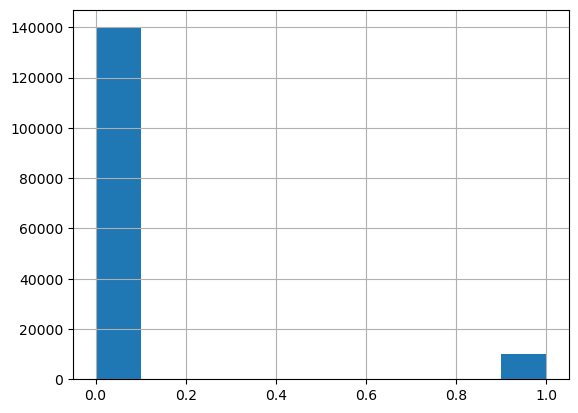

In [6]:
df['SeriousDlqin2yrs'].hist()

In [7]:
(df['SeriousDlqin2yrs']==0).sum()

np.int64(139974)

In [8]:
(df['SeriousDlqin2yrs']==1).sum()

np.int64(10026)

#### Classification Goal: predict 'SeriousDlqin2yrs' (Y) using the other features (X)

In [9]:
#'SeriousDlqin2yrs' is the target/class label, so it should not be in the input feature vector X
#'id' of a person is useless for the classification task
#so, we remove them from the table and get the input X
X=df.drop(['SeriousDlqin2yrs', 'id'], axis=1)
X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0
1,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0
2,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0
3,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0
4,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0


In [10]:
#Y is the target/class label
Y=df['SeriousDlqin2yrs']
Y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: SeriousDlqin2yrs, dtype: float64

In [11]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X=X.values
Y=Y.values

We split the data into training, validation and testing sets

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
#in the template, there is a different method to do the above split
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (108000, 10) (108000,)
validation: (12000, 10) (12000,)
test: (30000, 10) (30000,)


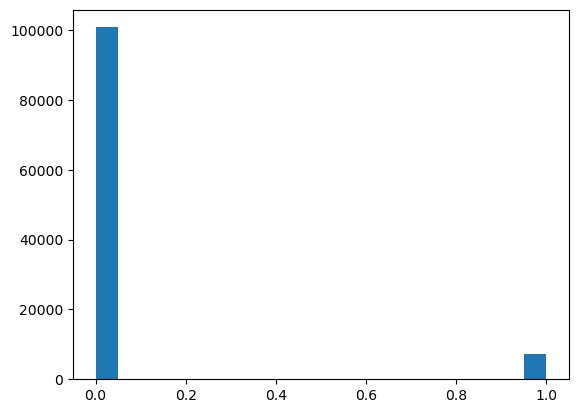

In [13]:
plt.hist(Y_train, bins=20);

In [14]:
(Y_train==0).sum()

np.int64(100824)

In [15]:
(Y_train==1).sum()

np.int64(7176)

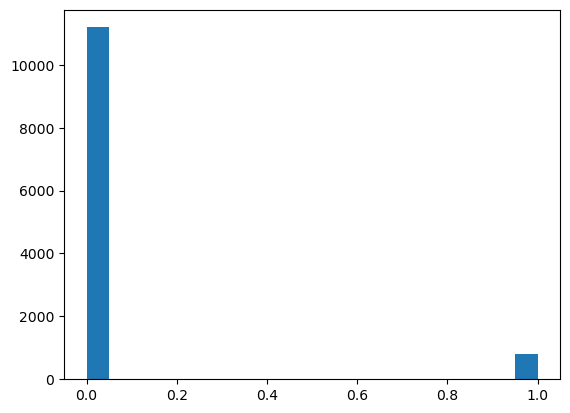

In [16]:
plt.hist(Y_val, bins=20);

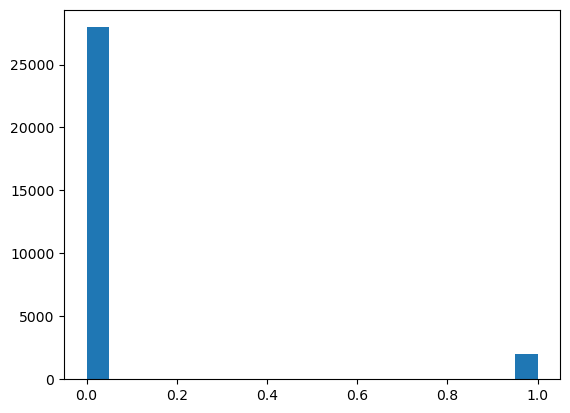

In [17]:
plt.hist(Y_test, bins=20);

In [18]:
# we need to use weighted classification accuracy
# try to understand it
def weighted_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the weighted classification accuracy
    M=confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k]/=M[k].sum()+1e-8    
    acc = M.diagonal().sum()/M.sum()
    return acc

In [19]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train) # think about why fit to X_train, not X ?
X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

#### build a LogisticRegression classifier as the baseline model

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
#set class_weight='balanced'
LR=LogisticRegression(penalty=None, class_weight='balanced', solver='newton-cg', random_state=0)
LR.fit(X_train, Y_train)
Y_val_pred=LR.predict(X_val)
confusion_val=confusion_matrix(Y_val, Y_val_pred)
acc_val=weighted_accuracy(confusion_val)
Y_test_pred=LR.predict(X_test)
confusion_test=confusion_matrix(Y_test, Y_test_pred)
acc_test=weighted_accuracy(confusion_test)
print('classification accuracy on validation set is ', acc_val)
print('classification accuracy on test set is ', acc_test)

classification accuracy on validation set is  0.720621
classification accuracy on test set is  0.7084789


## Your task begins here

#### Let's try GridSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import numpy as np

RF = RandomForestClassifier(
    n_estimators=20,
    class_weight='balanced',
    random_state=0
)

param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'max_samples': [0.5, 0.75, 1.0]
}

grid_search = GridSearchCV(
    estimator=RF,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, Y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
Y_test_pred = best_model.predict(X_test)
confusion_test = confusion_matrix(Y_test, Y_test_pred)

acc_test = weighted_accuracy(confusion_test)
print("Test weighted accuracy:", acc_test)
print("Confusion matrix:\n", confusion_test)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END max_depth=5, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=5; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=2; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=2; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=2; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=5; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=5; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=10; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=10; total time